## Step 1 - Climate Analysis and Exploration

In this assignment, we are exploring Hawaii climate (Percipitation and Temperature) based on sqlite database provided.

We will use Python and SQLAlchemy to do basic climate analysis and data exploration of your climate database. All plots will be plotted using Matplotlib

Following exploration and analysis are done

- Understand the tables
    - Using sqlchemy.inspect(), we will understand 
        * Tables in the sqlite database
        * columns of each table along with their data types
    - Using func.min() and func.max() functions with sqlalchemy, we will derive
        * Start date of the climate data and end date of the climate data
        * date that is exactly a year previous to the end date within the climate data

- Precipitation Analysis using a query to retrieve the last 12 months of precipitation data

- Station Analysis
    * Total number of stations
    * Most active stations
    * Explore last 12 months of temperature observation data (tobs) for the most active station
    * Plot a histogram with bins = 12

- Temperature Analysis 
    * Find the minimum, average and maximum temperature for dates same as trip planned dates but a previous year
    * Plot the min, avg, and max temperature from your previous query as a bar chart.
         * with average temperature as the bar height.
         * and peak-to-peak (tmax-tmin) value as the y error bar (yerr)
         
- Calculate the rainfall per weather station using the previous year's matching dates.

- Calculate the daily normals. Normals are the averages for the min, avg, and max temperatures
    * Create a list of dates for your trip in the format `%m-%d`. Use the `daily_normals` function to calculate the normals for each date string and append the results to a list.
    * Use Pandas to plot an area plot (`stacked=False`) for the daily normals
    
## Step 2 - Climate App using Flask

refer to file climate_explore_api.py for the above step

In [1]:
# Import all dependencies
import pandas as pd
import numpy as np

#SQLAlchemy libraries
from sqlalchemy import create_engine # library to create the connection between DB and Python
from sqlalchemy import func # library to use aggregate functions
from sqlalchemy.ext.declarative import declarative_base # to create new tables or other metadata
from sqlalchemy.ext.automap import automap_base # library specific to reflecting existing schema from DB and its mapping
from sqlalchemy import func, desc, and_, or_ # library provides basic sql functions like count, max, min, avg
from sqlalchemy.orm import Session # Library that sets session for SQL transaction
from sqlalchemy import inspect # library to inspect the SQL table from the Session
from sqlalchemy.sql.functions import coalesce # library to use check if null and replace with 0 or any value

# Datetime libraries
from datetime import datetime as dt, timedelta

# Plotting Libraries
import matplotlib
from matplotlib import style
import matplotlib.pyplot as plt

import os

In [2]:
# Declare global notebook variables

# declare the database file if sqlite
dbfile = "hawaii.sqlite"

#Matpotlib scheme and settings
style.use('fivethirtyeight')

#Image Output dir
image_dir = "images"

# data / resources dir
data_dir = "Resources"

#### Choose vacation start and end date

In [3]:
# Choose a vacation start and end date
vac_st_date = dt(2019,2,1)
vac_end_date = dt(2019,2,7)

print(f"Chosen Vacation Start Date : {vac_st_date}")
print(f"Chosen Vacation End Date : {vac_end_date}")



Chosen Vacation Start Date : 2019-02-01 00:00:00
Chosen Vacation End Date : 2019-02-07 00:00:00


#### Establish connection to the sqlite database using create_engine

In [4]:
#create Engine to connect to sqlite db#### Establish connection to the sqlite database using create_engine
engine = create_engine(f"sqlite:///{data_dir}/{dbfile}")

#### Reflect all the tables in the db to Base object using automap_base()

In [5]:
# decalre Base object and atuomap it to the schema
Base  = automap_base() # declare Base as an automap_base class
Base.prepare(engine, reflect = True) # reflect the metadata into Base class structure

#### Explore the databse using the Base object and inspect()


In [6]:
# explore classes / tables within db#### Establish connection to the sqlite database using create_engine
print("Tables in the sqlite database are :")
print(Base.classes.keys())

Tables in the sqlite database are :
['measurement', 'station']


In [7]:
#alternate way to inspect tables and columns

# declare inspector object called 'ins'
ins = inspect(engine)

tables_list = ins.get_table_names()

print(f"Tables in the Hawaii schema are {tables_list}")

# find the columns within each of the tables

for t in tables_list:
    print(f"Columns for Table : {t} \n----------------------------------------")
    [print(f"{c['name']}, {c['type']}") for c in ins.get_columns(t)]
    print(f"----------------------------------------\n")


Tables in the Hawaii schema are ['measurement', 'station']
Columns for Table : measurement 
----------------------------------------
id, INTEGER
station, TEXT
date, TEXT
prcp, FLOAT
tobs, FLOAT
----------------------------------------

Columns for Table : station 
----------------------------------------
id, INTEGER
station, TEXT
name, TEXT
latitude, FLOAT
longitude, FLOAT
elevation, FLOAT
----------------------------------------



#### Create References to Measurement and Station tables from the Base object

In [8]:
# Create references of the required Tables using Base.classes#### Establish connection to the sqlite database using create_engine
M = Base.classes.measurement
S = Base.classes.station

#### Create a session object that will be used to query the tables

In [9]:
# Start SQL query Session
session = Session(bind = engine)#### Establish connection to the sqlite database using create_engine

#### Query the first 5 rows from Measurement table

In [10]:
#query top 5 rows in measurement table and display results
sel_list = [M.id, M.station, M.date, M.prcp, M.tobs]

top5_measurement = session.query(*sel_list).limit(5).all()

top5_measurement

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

#### Query the Measurement table to get earliest and latest date observations in the DB. 

Also calculate the date for previous year from last observed date

In [32]:
#get Min and Max date in the DB for Measurement table

min_dt = dt.strptime(session.query(func.min(M.date)).scalar(),"%Y-%m-%d") 
max_dt = dt.strptime(session.query(func.max(M.date)).scalar(),"%Y-%m-%d") 

print(f"The minimum date is {min_dt}")
print(f"The maximum date is {max_dt}")

# One year prior to last date in the db

prev_year = (max_dt - timedelta(days = 365)).strftime("%Y-%m-%d")
print(f"Date year ago : {prev_year}")

The minimum date is 2010-01-01 00:00:00
The maximum date is 2017-08-23 00:00:00
Date year ago : 2016-08-23


### Precipitation Analysis

* Design a query to retrieve the last 12 months of precipitation data.

* Select only the `date` and `prcp` values.

* Load the query results into a Pandas DataFrame and set the index to the date column.

* Sort the DataFrame values by `date`.

* Plot the results using the DataFrame `plot` method.

* Use Pandas to print the summary statistics for the precipitation data

In [57]:
prcp_data = pd.DataFrame(session.query(M.date.label('Date'),coalesce(M.prcp,0).label('Precipitation')).\
                         filter(M.date.between(prev_year,max_dt)).order_by(M.date).all())


prcp_data.set_index('Date', inplace = True)

#prcp_data.sort_index()

prcp_data.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.00
2016-08-23,0.02


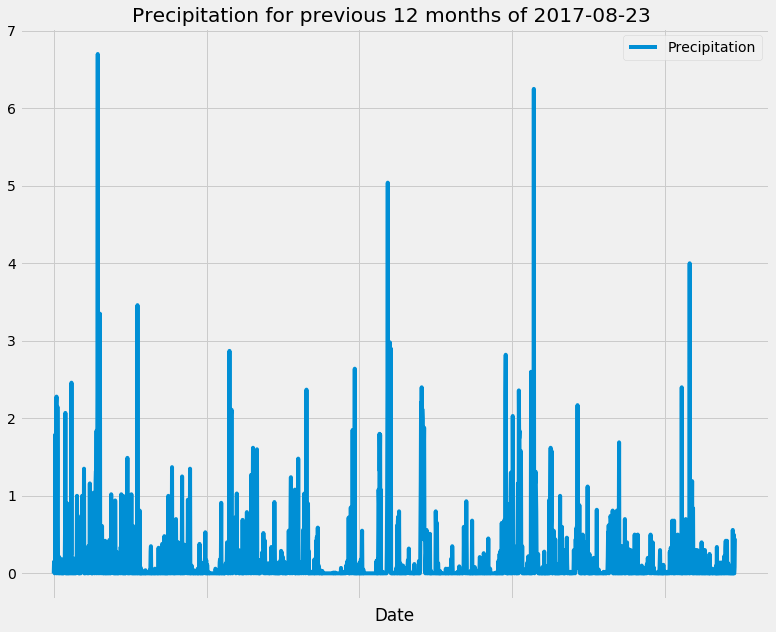

In [58]:
ax = prcp_data.plot(y = 'Precipitation', figsize = (11,9), \
                    title = f"Precipitation for previous 12 months of {max_dt.strftime('%Y-%m-%d')} ")

# save plot to image folder
plt.tight_layout()
plt.savefig(os.path.join(image_dir, "PreciptationvsDate.png"))
plt.show()


In [39]:
prcp_data.describe()

,Precipitation
count,2230.000000
mean,0.160664
std,0.442067
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,6.700000


### Station Analysis

* Design a query to calculate the total number of stations.

* Design a query to find the most active stations.

  * List the stations and observation counts in descending order.

  * Which station has the highest number of observations?

  * Hint: You may need to use functions such as `func.min`, `func.max`, `func.avg`, and `func.count` in your queries.

* Design a query to retrieve the last 12 months of temperature observation data (tobs).

  * Filter by the station with the highest number of observations.

  * Plot the results as a histogram with `bins=12`.

In [40]:
#Design a query to calculate the total number of stations.
num_stations = session.query(func.count(S.id)).scalar()

print(f"The total number of stations is : {num_stations}")

The total number of stations is : 9


In [41]:
# Design a query to find the most active stations.
# List the stations and observation counts in descending order.
# Which station has the highest number of observations?

active_stations = session.query(M.station.label('Station'), func.count(M.id).label("Obs")).group_by(M.station).\
                        order_by(desc(func.count(M.id))).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [42]:
print(f"The most active station is {active_stations[0][0]} with {active_stations[0][1]} observations")

The most active station is USC00519281 with 2772 observations


In [43]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
min_tobs, max_tobs, avg_tobs = session.query(func.min(M.tobs), func.max(M.tobs), func.avg(M.tobs)).\
                filter(M.station == active_stations[0][0]).\
                         one()

print(f"The minimum Temperature observed at station {active_stations[0][0]} is {min_tobs}")
print(f"The maximum Temperature observed at station {active_stations[0][0]} is {max_tobs}")
print(f"The average Temperature observed at station {active_stations[0][0]} is {avg_tobs}")

The minimum Temperature observed at station USC00519281 is 54.0
The maximum Temperature observed at station USC00519281 is 85.0
The average Temperature observed at station USC00519281 is 71.66378066378067


In [44]:
# Design a query to retrieve the last 12 months of temperature observation data (tobs).
# Filter by the station with the highest number of observations.
# Plot the results as a histogram with bins=12.

tobs_data = pd.DataFrame(session.query(M.date.label('Date'), coalesce(M.tobs.label("TempObs"),0)).\
                filter(M.date.between(prev_year, max_dt)).filter(M.station == active_stations[0][0]).\
                         order_by(M.date).all(), columns = ['Date','TempObs'])
tobs_data.head()

,Date,TempObs
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0


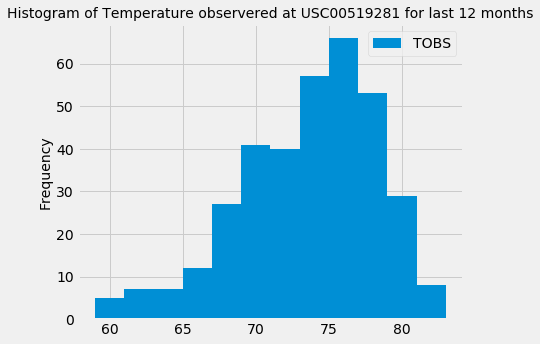

In [45]:
fig, axs = plt.subplots(figsize = (7,5))
tobs_data.hist(bins = 12, ax = axs, label = 'TOBS')
axs.set_title(f"Histogram of Temperature observered at {active_stations[0][0]} for last 12 months", fontsize = 14)
axs.set_ylabel("Frequency", fontsize = 14)
plt.legend(loc = 'best')

plt.tight_layout()
plt.savefig(os.path.join(image_dir,"Tobs_hist.png"))

plt.show()


### Temperature Analysis (Optional)

* The starter notebook contains a function called `calc_temps` that will accept a start date and end date in the format `%Y-%m-%d` and return the minimum, average, and maximum temperatures for that range of dates.

* Use the `calc_temps` function to calculate the min, avg, and max temperatures for your trip using the matching dates from the previous year (i.e., use "2017-01-01" if your trip start date was "2018-01-01").

* Plot the min, avg, and max temperature from your previous query as a bar chart.

  * Use the average temperature as the bar height.

  * Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr).

In [46]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(st_dt, end_dt):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        st_dt (string): A date string in the format %Y-%m-%d
        end_dt (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    return session.query(func.min(M.tobs), func.avg(M.tobs), func.max(M.tobs)).\
                filter(M.date.between(st_dt, end_dt)).one()

#print(calc_temps('2012-02-28', '2012-03-05'))

In [47]:
print(f'The vacation start date and end date is {vac_st_date} and {vac_end_date}')

The vacation start date and end date is 2019-02-01 00:00:00 and 2019-02-07 00:00:00


In [48]:
# Use the calc_temps function to calculate the min, avg, and max temperatures for your trip 
# using the matching dates from the previous year 
# (i.e., use "2017-01-01" if your trip start date was "2018-01-01").

## CONSTRUCT THE DATE FOR THE QUERY BASED on VACATION DATES AND MAX DATE in DB
# Extract the month and day from vacation start and end dates

qry_st_dt = str(max_dt.year) + "-" + vac_st_date.strftime("%m-%d")
qry_end_dt = str(max_dt.year) + "-" + vac_end_date.strftime("%m-%d")

print(f"query dates are {qry_st_dt} and {qry_end_dt}")

# CALL THE `calc-temps` function to get Observered Temps (min, avg and Max)

min_tobs, avg_tobs, max_tobs = calc_temps(qry_st_dt, qry_end_dt)

print(f"The minimum, average and maximum temperature observed are {min_tobs},{avg_tobs},{max_tobs}")

query dates are 2017-02-01 and 2017-02-07
The minimum, average and maximum temperature observed are 59.0,69.42222222222222,80.0


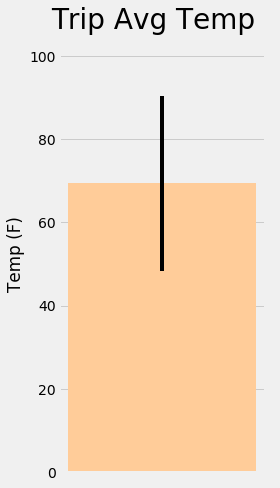

In [49]:
fig, ax = plt.subplots(figsize = (4,7))

ax.bar(x = 1, height = avg_tobs, yerr = (max_tobs - min_tobs), color = '#FFCC99')

ax.set_ylabel(ylabel = "Temp (F)")
ax.set_title("Trip Avg Temp  ", fontsize = 28)
ax.set_ylim(0, 105, 5)
ax.set_xticks([])
ax.grid(True, axis = 'y')

plt.tight_layout()
plt.savefig(os.path.join(image_dir, "Vac_Temp_obs.png"))
plt.show()

### Other Recommended Analysis (Optional)

* The following are optional challenge queries. These are highly recommended to attempt, but not required for the homework.

  * Calculate the rainfall per weather station using the previous year's matching dates.

* Calculate the daily normals. Normals are the averages for the min, avg, and max temperatures.

  * You are provided with a function called `daily_normals` that will calculate the daily normals for a specific date. This date string will be in the format `%m-%d`. Be sure to use all historic tobs that match that date string.

  * Create a list of dates for your trip in the format `%m-%d`. Use the `daily_normals` function to calculate the normals for each date string and append the results to a list.

  * Load the list of daily normals into a Pandas DataFrame and set the index equal to the date.

  * Use Pandas to plot an area plot (`stacked=False`) for the daily normals.

In [50]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rainfall_data = pd.DataFrame(session.query(S.station.label('Station'), S.name.label('Station_Name'), \
                                            S.latitude.label('Latitude'), S.longitude.label('Logitude'), \
                                           S.elevation.label('Elevation'), coalesce(M.prcp,0).label('Precipitation')).\
                filter(and_(M.station == S.station, M.date.between(qry_st_dt,qry_end_dt))).\
                group_by(S.id).order_by(desc(coalesce(M.prcp,0))).all())

rainfall_data

,Station,Station_Name,Latitude,Logitude,Elevation,Precipitation
0,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,1.80
1,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,1.79
2,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,1.32
3,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,1.08
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.90
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.51
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.00


#### Part 2
* Calculate the daily normals. Normals are the averages for the min, avg, and max temperatures.

  * You are provided with a function called `daily_normals` that will calculate the daily normals for a specific date. This date string will be in the format `%m-%d`. Be sure to use all historic tobs that match that date string.

 * Create a list of dates for your trip in the format `%m-%d`. Use the `daily_normals` function to calculate the normals for each date string and append the results to a list.

  * Load the list of daily normals into a Pandas DataFrame and set the index equal to the date.

  * Use Pandas to plot an area plot (`stacked=False`) for the daily normals.

In [51]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    return session.query(func.min(M.tobs), func.avg(M.tobs), func.max(M.tobs)).\
                filter(func.strftime('%m-%d',M.date) == date).one()

#test
daily_normals('01-02')



(60.0, 69.39622641509433, 77.0)

In [52]:
#generate date ranges between vacation start and end dates

dt_rng = pd.date_range(vac_st_date.strftime("%Y-%m-%d"), vac_end_date.strftime("%Y-%m-%d"))
dt_rng

DatetimeIndex(['2019-02-01', '2019-02-02', '2019-02-03', '2019-02-04',
               '2019-02-05', '2019-02-06', '2019-02-07'],
              dtype='datetime64[ns]', freq='D')

In [53]:
#extract -mnth-date from each date in the range
m_dt_str = [v.strftime('%m-%d') for v in dt_rng]
m_dt_str

['02-01', '02-02', '02-03', '02-04', '02-05', '02-06', '02-07']

In [54]:
# Loop to get the daily_normals for each of the mnth-day strings
dly_norm = pd.DataFrame([daily_normals(s) for s in m_dt_str], columns = ['TMin','TAvg','TMax'])
                        
dly_norm['Date'] = [v.strftime('%Y-%m-%d') for v in dt_rng]

dly_norm.set_index('Date', inplace = True)
dly_norm

,TMin,TAvg,TMax
Date,,,
2019-02-01,56.0,68.140351,78.0
2019-02-02,59.0,68.859649,77.0
2019-02-03,58.0,67.796610,77.0
2019-02-04,61.0,68.140351,76.0
2019-02-05,59.0,69.684211,80.0
2019-02-06,58.0,70.389831,77.0
2019-02-07,60.0,69.000000,77.0


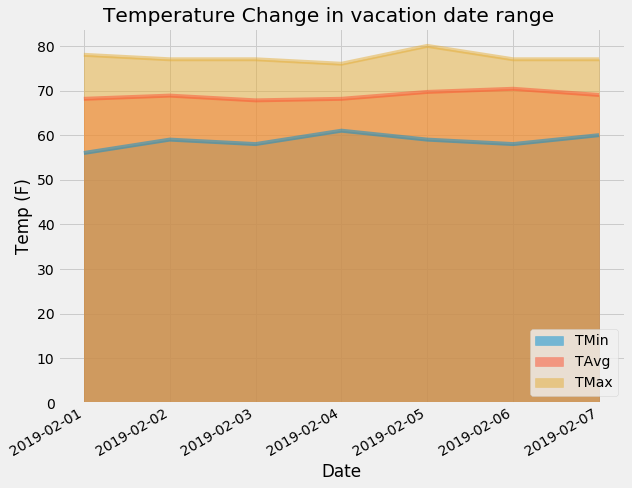

In [55]:

fig, axs = plt.subplots(figsize = (9,7))
dly_norm.plot(kind = 'area', stacked = False, ax = axs)

axs.set(xlabel = 'Date', ylabel = "Temp (F)", title = 'Temperature Change in vacation date range    ')
axs.set_xticks(range(len(dly_norm)))
axs.set_xticklabels(dly_norm.index, rotation = 30, ha = 'right')

axs.legend(loc = 'lower right')

plt.tight_layout()
plt.savefig(os.path.join(image_dir, "TempChng_areaplot.png"))
plt.show()

#### All work done -- close session

In [56]:
session.close()